# FastAPI NLP API Demo

This notebook demonstrates how to interact with the NLP API endpoints.

In [36]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import websocket
import threading
from IPython.display import display, HTML, JSON, clear_output

In [37]:
# API configuration
BASE_URL = "http://localhost:8000/api/v1"
# Default credentials (update these)
USERNAME = "admin"
PASSWORD = "password"

## 1. Authentication

First, let's authenticate with the API to get a token.

In [38]:
def get_token(username, password):
    """Get authentication token from the API."""
    response = requests.post(
        f"{BASE_URL}/token",
        data={"username": username, "password": password},
        headers={"Content-Type": "application/x-www-form-urlencoded"}
    )
    
    if response.status_code == 200:
        token_data = response.json()
        return token_data["access_token"]
    else:
        print(f"Authentication failed with status code {response.status_code}")
        print(response.text)
        return None

In [39]:
# Get the authentication token
token = get_token(USERNAME, PASSWORD)

if token:
    print(f"Authentication successful! Token obtained.")
    # Set up the default headers with our token
    headers = {
        "Authorization": f"Bearer {token}",
        "Content-Type": "application/json"
    }
else:
    print("Failed to get token. Please check your credentials.")

Authentication successful! Token obtained.


## 2. Health Check

Let's check if the API is healthy and all models are available.

<IPython.core.display.JSON object>

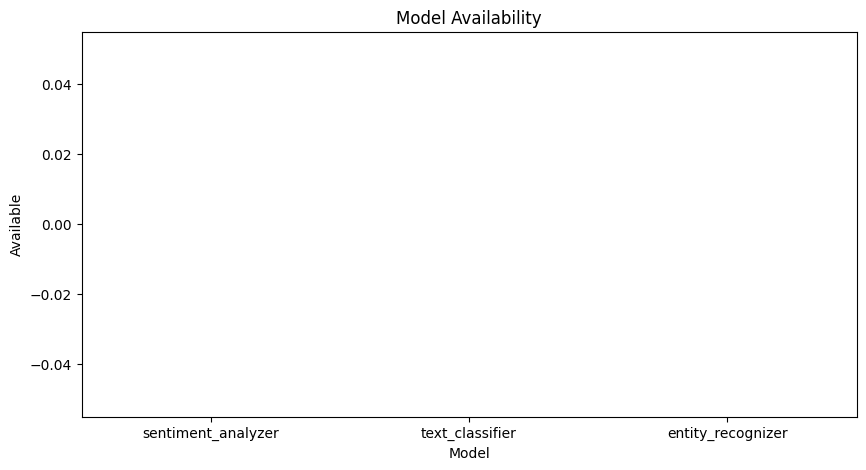

In [40]:
def check_health():
    """Check the health status of the API."""
    response = requests.get(f"{BASE_URL}/health")
    return response.json()

health_status = check_health()
display(JSON(health_status))

# Visual representation of model availability
if "models" in health_status:
    models_df = pd.DataFrame([{"model": k, "available": v} for k, v in health_status["models"].items()])
    plt.figure(figsize=(10, 5))
    sns.barplot(x="model", y="available", data=models_df)
    plt.title("Model Availability")
    plt.ylabel("Available")
    plt.xlabel("Model")
    plt.show()

## 3. Get User Information

Let's check the current user's information.

In [41]:
def get_user_info():
    """Get current user information."""
    response = requests.get(
        f"{BASE_URL}/users/me",
        headers=headers
    )
    return response.json()

user_info = get_user_info()
display(JSON(user_info))

<IPython.core.display.JSON object>

## 4. Sentiment Analysis

Let's analyze the sentiment of some example texts.

In [42]:
def analyze_sentiment(text, language="en"):
    """Analyze the sentiment of the given text."""
    payload = {
        "text": text,
        "language": language
    }
    
    response = requests.post(
        f"{BASE_URL}/sentiment",
        headers=headers,
        json=payload
    )
    
    return response.json()

In [43]:
# Test with some example texts
example_texts = [
    "I love this product, it's amazing!",
    "This is the worst experience ever.",
    "The package arrived on time.",
    "I'm not sure what to think about this."
]

sentiment_results = []
for text in example_texts:
    result = analyze_sentiment(text)
    sentiment_results.append(result)
    display(JSON(result))
    
# Create a visualization of the sentiment scores
sentiment_df = pd.DataFrame([
    {"text": r["text"], "sentiment": r["sentiment"], "score": r["score"]} 
    for r in sentiment_results
])

plt.figure(figsize=(10, 6))
bars = sns.barplot(x="text", y="score", hue="sentiment", data=sentiment_df)
plt.title("Sentiment Analysis Results")
plt.ylabel("Confidence Score")
plt.xlabel("")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

## 5. Named Entity Recognition

Let's extract entities from some sample texts.

In [22]:
def extract_entities(text):
    """Extract named entities from the given text."""
    payload = {"text": text}
    
    response = requests.post(
        f"{BASE_URL}/entities",
        headers=headers,
        json=payload
    )
    
    return response.json()

<IPython.core.display.JSON object>

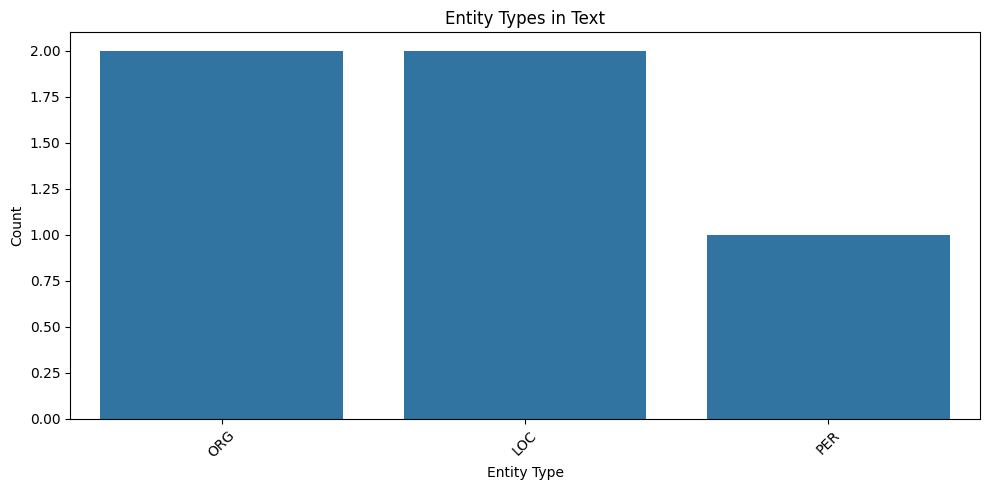

In [23]:
ner_text = "Apple is looking to buy U.K. startup for $1 billion in January 2023. Microsoft CEO Satya Nadella announced the news in New York."
entities = extract_entities(ner_text)
display(JSON(entities))

# Create a visualization of entity types
if entities and "entities" in entities:
    entities_df = pd.DataFrame(entities["entities"])
    
    # Count entities by type
    entity_counts = entities_df["type"].value_counts().reset_index()
    entity_counts.columns = ["entity_type", "count"]
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x="entity_type", y="count", data=entity_counts)
    plt.title("Entity Types in Text")
    plt.ylabel("Count")
    plt.xlabel("Entity Type")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Display the annotated text
    def highlight_entities(text, entities):
        """Highlight entities in text with HTML colors."""
        colors = {
            "PERSON": "#FF9999",
            "ORG": "#99FF99",
            "LOC": "#9999FF",
            "DATE": "#FFFF99",
            "TIME": "#99FFFF",
            "MONEY": "#FF99FF",
            "PERCENT": "#FFCC99",
        }
        
        # Sort entities by start position (reversed to avoid index issues)
        sorted_entities = sorted(entities, key=lambda x: x["start"], reverse=True)
        
        result = text
        for entity in sorted_entities:
            start = entity["start"]
            end = entity["end"]
            entity_type = entity["type"]
            entity_text = text[start:end]
            color = colors.get(entity_type, "#CCCCCC")
            
            highlight = f'<span style="background-color: {color}; padding: 2px; border-radius: 3px;" title="{entity_type}">{entity_text}</span>'
            result = result[:start] + highlight + result[end:]
            
        return result
    
    highlighted_text = highlight_entities(entities["text"], entities["entities"])
    display(HTML(f"<p style='font-size: 16px; line-height: 1.5;'>{highlighted_text}</p>"))

## 6. Entity Filtering

Let's try filtering entities by type and confidence score.

In [24]:
def filter_entities(text, entity_types=None, min_score=0.5):
    """Filter entities by type and minimum confidence score."""
    params = {"text": text, "min_score": min_score}
    
    if entity_types:
        params["entity_types"] = entity_types
    
    response = requests.get(
        f"{BASE_URL}/entities/filter",
        headers=headers,
        params=params
    )
    
    return response.json()

<IPython.core.display.JSON object>

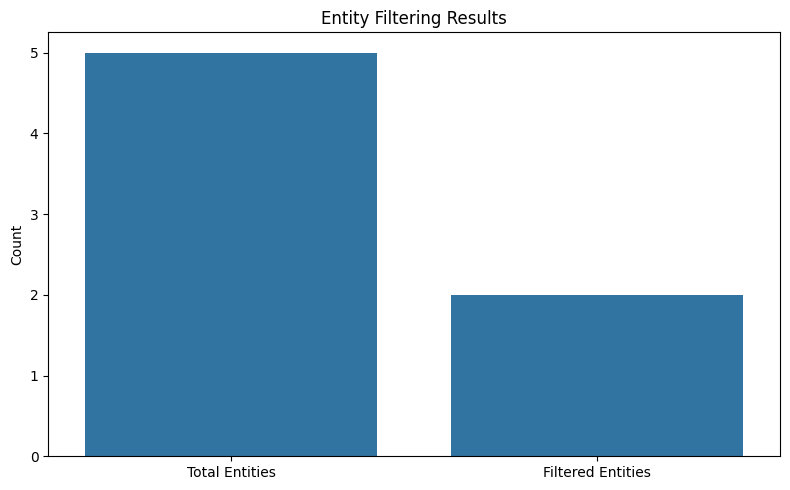

In [25]:
# Filter only for organizations and persons with high confidence
filtered_entities = filter_entities(
    ner_text, 
    entity_types=["ORG", "PERSON"], 
    min_score=0.7
)

display(JSON(filtered_entities))

# Compare filtered vs total entities count
if "filtered_from" in filtered_entities and "filtered_to" in filtered_entities:
    filter_stats = pd.DataFrame([
        {"category": "Total Entities", "count": filtered_entities["filtered_from"]},
        {"category": "Filtered Entities", "count": filtered_entities["filtered_to"]}
    ])
    
    plt.figure(figsize=(8, 5))
    sns.barplot(x="category", y="count", data=filter_stats)
    plt.title("Entity Filtering Results")
    plt.ylabel("Count")
    plt.xlabel("")
    plt.tight_layout()
    plt.show()

## 7. Text Classification

Let's classify some sample texts into categories.

In [26]:
def classify_text(text, labels, multi_label=False):
    """Classify text into given categories."""
    payload = {
        "text": text,
        "labels": labels,
        "multi_label": multi_label
    }
    
    response = requests.post(
        f"{BASE_URL}/classify",
        headers=headers,
        json=payload
    )
    
    return response.json()

In [27]:
# Get classification presets
def get_classification_preset(preset_name):
    """Get predefined label sets for classification."""
    response = requests.get(
        f"{BASE_URL}/classify/presets/{preset_name}",
        headers=headers
    )
    
    return response.json()

# Get the topics preset
topics_preset = get_classification_preset("topics")
display(JSON(topics_preset))

<IPython.core.display.JSON object>

<IPython.core.display.JSON object>

<IPython.core.display.JSON object>

<IPython.core.display.JSON object>

<IPython.core.display.JSON object>

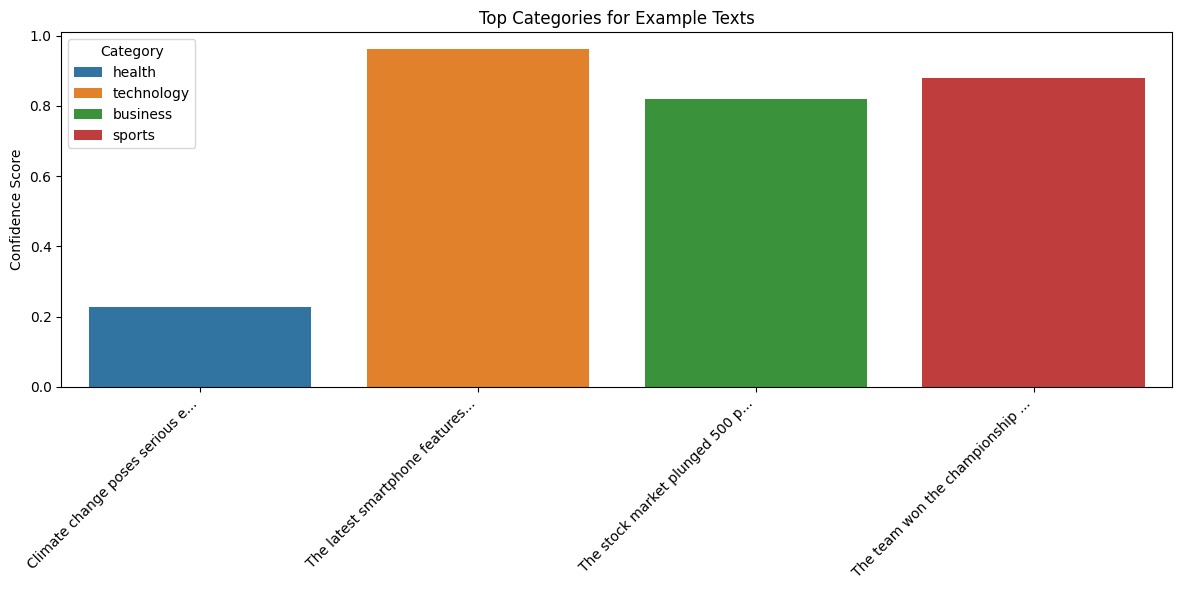

In [28]:
# Example texts for classification
classification_examples = [
    "Climate change poses serious environmental challenges",
    "The latest smartphone features a 108MP camera and advanced AI",
    "The stock market plunged 500 points due to economic concerns",
    "The team won the championship with a last-minute goal"
]

# Use the topics from the preset
topic_labels = topics_preset["labels"]

# Classify each example text
classification_results = []
for text in classification_examples:
    result = classify_text(text, topic_labels)
    classification_results.append(result)
    display(JSON(result))
    
# Visualize top categories for each text
classification_data = []
for result in classification_results:
    # Sort labels by score (highest first) and get top label
    top_label = sorted(result["labels"], key=lambda x: x.get("score", 0), reverse=True)[0]
    classification_data.append({
        "text": result["text"][:30] + "...",  # Truncate long texts
        "top_category": top_label.get("label"),
        "score": top_label.get("score")
    })

class_df = pd.DataFrame(classification_data)
plt.figure(figsize=(12, 6))
bars = sns.barplot(x="text", y="score", hue="top_category", data=class_df)
plt.title("Top Categories for Example Texts")
plt.ylabel("Confidence Score")
plt.xlabel("")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.legend(title="Category")
plt.show()

## 8. Custom Classification with Query Parameters

Let's try the custom classification endpoint that uses query parameters.

In [29]:
def custom_classify(text, labels):
    """Classify text using query parameters."""
    params = {
        "text": text,
        "labels": labels
    }
    
    response = requests.post(
        f"{BASE_URL}/classify/custom",
        headers=headers,
        params=params
    )
    
    return response.json()

# Try with intent classification
intent_result = custom_classify(
    "How do I reset my password?", 
    ["question", "complaint", "feedback", "request"]
)
display(JSON(intent_result))

<IPython.core.display.JSON object>

"""
## 8. Streaming Text Analysis

Now let's test the streaming analysis capabilities of the API.
"""

In [30]:
def test_stream_analyze_text():
    """Demonstrate streaming text analysis using Server-Sent Events."""
    # Example long text for analysis
    text = """The Apple conference in San Francisco was attended by Tim Cook, who announced new products.
    Microsoft and Google were also represented at the event.
    The new iPhone impressed many analysts with its innovative features.
    The event took place at the Moscone Center in downtown San Francisco.
    Investors reacted positively to the announcements, with Apple stock rising 3% after the conference."""
    
    # Prepare the payload
    payload = {
        "text": text,
        "analysis_types": ["sentiment", "entities"],
        "chunk_delay": 0.5  # Add artificial delay for demonstration purposes
    }
    
    print("Starting streaming analysis...")
    print(f"Text to analyze: {text[:100]}...")
    
    # Make the request with stream=True to handle the SSE stream
    response = requests.post(
        f"{BASE_URL}/streaming/analyze",
        headers=headers,
        json=payload,
        stream=True
    )
    
    if response.status_code != 200:
        print(f"Error: {response.status_code} - {response.text}")
        return
    
    # Process the SSE stream
    print("\nReceiving streaming results:\n")
    line_buffer = ""
    
    for line in response.iter_lines():
        if line:
            line_str = line.decode('utf-8')
            
            # SSE lines start with "data: "
            if line_str.startswith("data: "):
                data_json = line_str[6:]  # Remove "data: " prefix
                try:
                    data = json.loads(data_json)
                    
                    # Handle different types of messages
                    if "status" in data:
                        # Status message
                        print(f"Status: {data['status']} - {data.get('message', '')}")
                    else:
                        # Chunk result
                        print(f"\nChunk {data['chunk_id'] + 1}/{data['total_chunks']} " +
                              f"({data['progress'] * 100:.1f}%):")
                        print(f"Text: {data['chunk_text']}")
                        
                        if "sentiment" in data:
                            print(f"Sentiment: {data['sentiment']} " +
                                  f"(Score: {data['sentiment_score']:.4f})")
                        
                        if "entities" in data and data["entities"]:
                            print("Entities:")
                            for entity in data["entities"]:
                                print(f"  - {entity['word']} ({entity['entity']})")
                        
                        print(f"Processing time: {data['processing_time']:.4f} seconds")
                
                except json.JSONDecodeError:
                    print(f"Error parsing JSON: {data_json}")
    
    print("\nStreaming completed.")

# Run the streaming test
test_stream_analyze_text()

Starting streaming analysis...
Text to analyze: The Apple conference in San Francisco was attended by Tim Cook, who announced new products.
    Micr...

Receiving streaming results:

Status: processing - Starting analysis

Chunk 1/2 (50.0%):
Text: The Apple conference in San Francisco was attended by Tim Cook, who announced new products. Microsoft and Google were also represented at the event. The new iPhone impressed many analysts with its innovative features.
Sentiment: positive (Score: 0.9996)
Entities:
  - Apple (ORG)
  - SanFrancisco (LOC)
  - TimCook (PER)
  - Microsoft (ORG)
  - Google (ORG)
  - iPhone (MISC)
Processing time: 0.7156 seconds

Chunk 2/2 (100.0%):
Text: The event took place at the Moscone Center in downtown San Francisco. Investors reacted positively to the announcements, with Apple stock rising 3% after the conference.
Sentiment: positive (Score: 0.9927)
Entities:
  - Mo (LOC)
  - ##sconeCenter (LOC)
  - SanFrancisco (LOC)
  - Apple (ORG)
Processing time: 0.5505 s

## 9. Interactive Streaming Demo with Visualization

Let's create a more advanced demo with visualization to better demonstrate
the streaming capabilities.

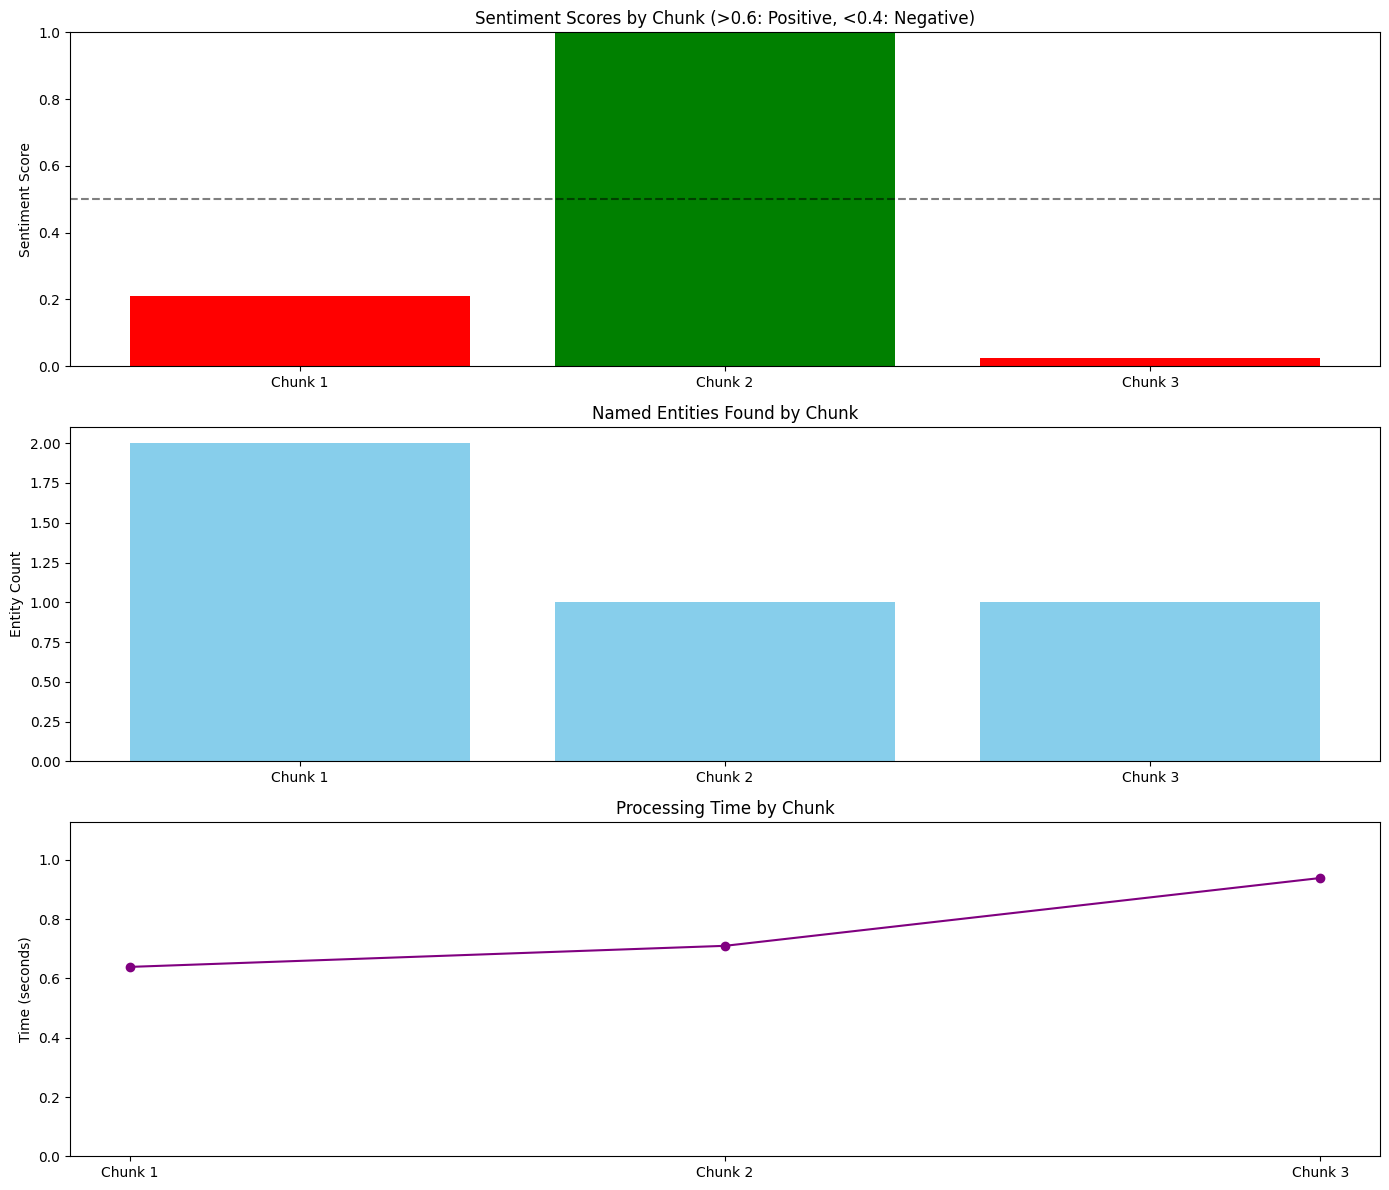


Processing chunk 3/3 (100.0% complete):
Text: Tech reviewers praised the new design and speed enhancements of the MacBook. Meanwhile, competitors scrambled to announce their own product launches. Overall market reaction was mixed as consumers evaluated the different options available.
Sentiment: negative (Score: 0.0247)
Entities:
  - MacBook (MISC)
Status: completed - Analysis complete

Streaming Analysis Summary:


,Chunk,Sentiment Score,Entity Count,Processing Time
0,Chunk 1,0.211166,2,0.638961
1,Chunk 2,0.999345,1,0.710094
2,Chunk 3,0.024651,1,0.938977


<Figure size 1600x1200 with 0 Axes>

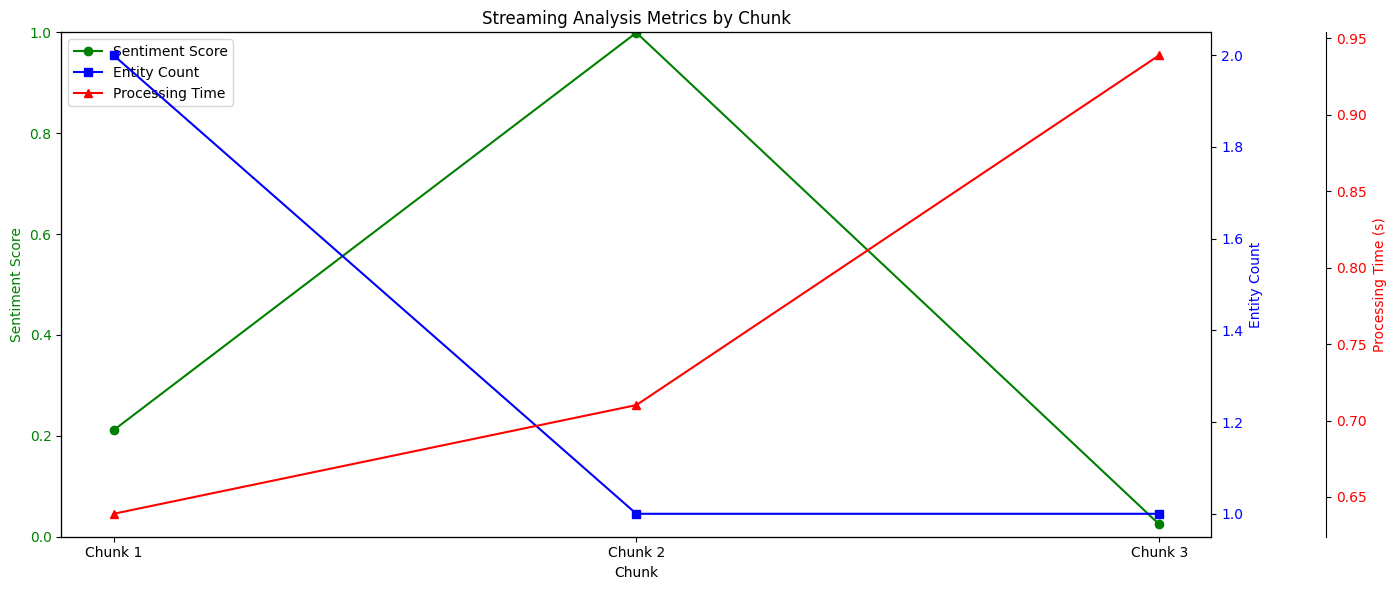


Streaming analysis visualization completed.


In [31]:
def visualize_streaming_analysis():
    """Create a visualization of streaming analysis results."""
    # Set up a larger example text with mixed sentiments
    text = """The new iPhone launch was a tremendous success with record-breaking sales.
    However, some users complained about battery life issues.
    Apple's CEO announced that software updates would address these concerns.
    Critics were skeptical that software alone could fix hardware limitations.
    Nevertheless, investors remained confident in the company's long-term strategy.
    The company also unveiled their latest MacBook Pro with significant performance improvements.
    Tech reviewers praised the new design and speed enhancements of the MacBook.
    Meanwhile, competitors scrambled to announce their own product launches.
    Overall market reaction was mixed as consumers evaluated the different options available."""
    
    # Prepare the payload
    payload = {
        "text": text,
        "analysis_types": ["sentiment", "entities"],
        "chunk_delay": 0.3  # Add artificial delay for demonstration purposes
    }
    
    # Set up visualization
    plt.figure(figsize=(14, 8))
    
    # Tracking data
    sentiment_scores = []
    chunk_texts = []
    entities_count = []
    processing_times = []
    progress_values = []
    
    print("Starting interactive streaming analysis visualization...\n")
    
    # Make the request with stream=True to handle the SSE stream
    response = requests.post(
        f"{BASE_URL}/streaming/analyze",
        headers=headers,
        json=payload,
        stream=True
    )
    
    if response.status_code != 200:
        print(f"Error: {response.status_code} - {response.text}")
        return
    
    # Process the SSE stream
    for line in response.iter_lines():
        if line:
            line_str = line.decode('utf-8')
            
            # SSE lines start with "data: "
            if line_str.startswith("data: "):
                data_json = line_str[6:]  # Remove "data: " prefix
                try:
                    data = json.loads(data_json)
                    
                    # Status message
                    if "status" in data:
                        print(f"Status: {data['status']} - {data.get('message', '')}")
                        continue
                    
                    # Chunk result - update visualization data
                    chunk_id = data['chunk_id']
                    chunk_text = data['chunk_text']
                    
                    # Get data from chunk
                    sentiment_score = data.get('sentiment_score', 0.5)
                    entity_count = len(data.get('entities', []))
                    processing_time = data.get('processing_time', 0)
                    progress = data.get('progress', 0)
                    
                    # Store data for visualization
                    sentiment_scores.append(sentiment_score)
                    chunk_texts.append(f"Chunk {chunk_id+1}")
                    entities_count.append(entity_count)
                    processing_times.append(processing_time)
                    progress_values.append(progress)
                    
                    # Update visualization
                    clear_output(wait=True)
                    
                    # Create a figure with 3 subplots
                    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12))
                    
                    # Plot 1: Sentiment scores by chunk
                    sentiment_colors = ['red' if s < 0.4 else 'green' if s > 0.6 else 'gray' 
                                       for s in sentiment_scores]
                    ax1.bar(chunk_texts, sentiment_scores, color=sentiment_colors)
                    ax1.set_ylim(0, 1)
                    ax1.set_title('Sentiment Scores by Chunk (>0.6: Positive, <0.4: Negative)')
                    ax1.set_ylabel('Sentiment Score')
                    ax1.axhline(y=0.5, color='black', linestyle='--', alpha=0.5)
                    
                    # Plot 2: Entity count by chunk
                    ax2.bar(chunk_texts, entities_count, color='skyblue')
                    ax2.set_title('Named Entities Found by Chunk')
                    ax2.set_ylabel('Entity Count')
                    
                    # Plot 3: Processing time by chunk
                    ax3.plot(chunk_texts, processing_times, marker='o', color='purple')
                    ax3.set_title('Processing Time by Chunk')
                    ax3.set_ylabel('Time (seconds)')
                    ax3.set_ylim(0, max(processing_times) * 1.2 if processing_times else 1)
                    
                    plt.tight_layout()
                    plt.show()
                    
                    # Print current chunk info
                    print(f"\nProcessing chunk {chunk_id + 1}/{data['total_chunks']} " +
                          f"({progress * 100:.1f}% complete):")
                    print(f"Text: {chunk_text}")
                    
                    if "sentiment" in data:
                        sentiment = data['sentiment']
                        print(f"Sentiment: {sentiment} (Score: {sentiment_score:.4f})")
                    
                    if "entities" in data and data["entities"]:
                        print("Entities:")
                        for entity in data["entities"]:
                            print(f"  - {entity['word']} ({entity['entity']})")
                    
                except json.JSONDecodeError:
                    print(f"Error parsing JSON: {data_json}")
    
    # Final visualization with all data
    plt.figure(figsize=(16, 12))
    
    # Create summary dataframe
    summary_df = pd.DataFrame({
        'Chunk': chunk_texts,
        'Sentiment Score': sentiment_scores,
        'Entity Count': entities_count,
        'Processing Time': processing_times
    })
    
    print("\nStreaming Analysis Summary:")
    display(summary_df)
    
    # Final visualization with all metrics together
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Plot sentiment scores and entities count on the same graph with different scales
    ax.set_xlabel('Chunk')
    ax.set_ylabel('Sentiment Score', color='green')
    line1 = ax.plot(chunk_texts, sentiment_scores, 'g-', marker='o', label='Sentiment Score')
    ax.tick_params(axis='y', labelcolor='green')
    ax.set_ylim(0, 1)
    
    ax2 = ax.twinx()
    ax2.set_ylabel('Entity Count', color='blue')
    line2 = ax2.plot(chunk_texts, entities_count, 'b-', marker='s', label='Entity Count')
    ax2.tick_params(axis='y', labelcolor='blue')
    
    # Add a third y-axis for processing time
    ax3 = ax.twinx()
    ax3.spines["right"].set_position(("axes", 1.1))
    ax3.set_ylabel('Processing Time (s)', color='red')
    line3 = ax3.plot(chunk_texts, processing_times, 'r-', marker='^', label='Processing Time')
    ax3.tick_params(axis='y', labelcolor='red')
    
    # Add legends
    lines = line1 + line2 + line3
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc='upper left')
    
    plt.title('Streaming Analysis Metrics by Chunk')
    plt.tight_layout()
    plt.show()
    
    print("\nStreaming analysis visualization completed.")

# Run the interactive visualization
visualize_streaming_analysis()

## 10. Compare Streaming vs. Non-Streaming Analysis

Let's compare the streaming analysis with the traditional non-streaming approach for the same text.

Comparing streaming vs. non-streaming analysis for the same text...

Text length: 760 characters

Regular analysis completed in 2.37 seconds
Streaming analysis:
  - Time to first result: 0.92 seconds
  - Total time: 2.49 seconds
  - Number of chunks: 3


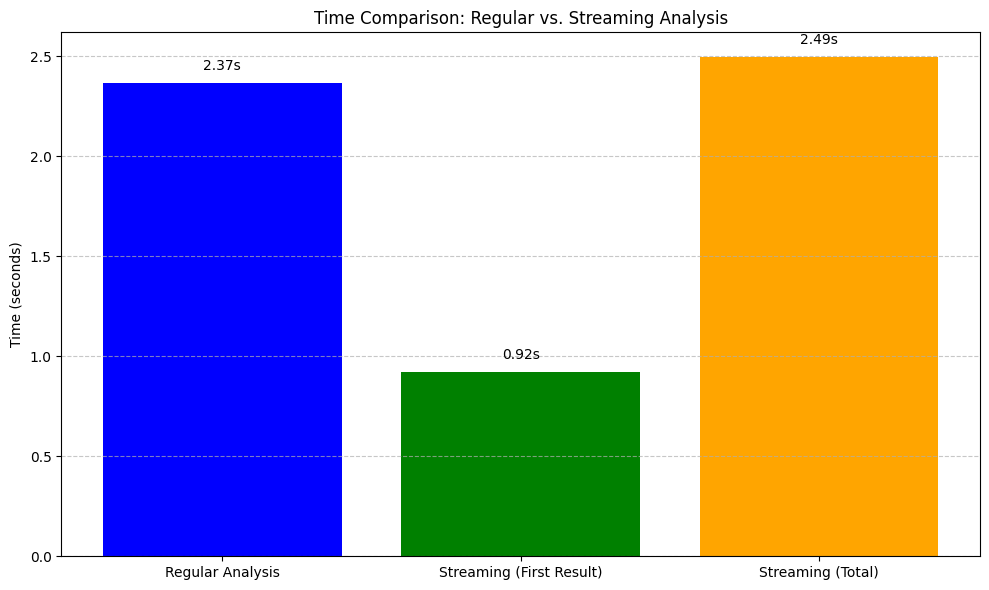


Entity extraction comparison:
  - Regular analysis: 10 entities found
  - Streaming analysis: 10 entities found


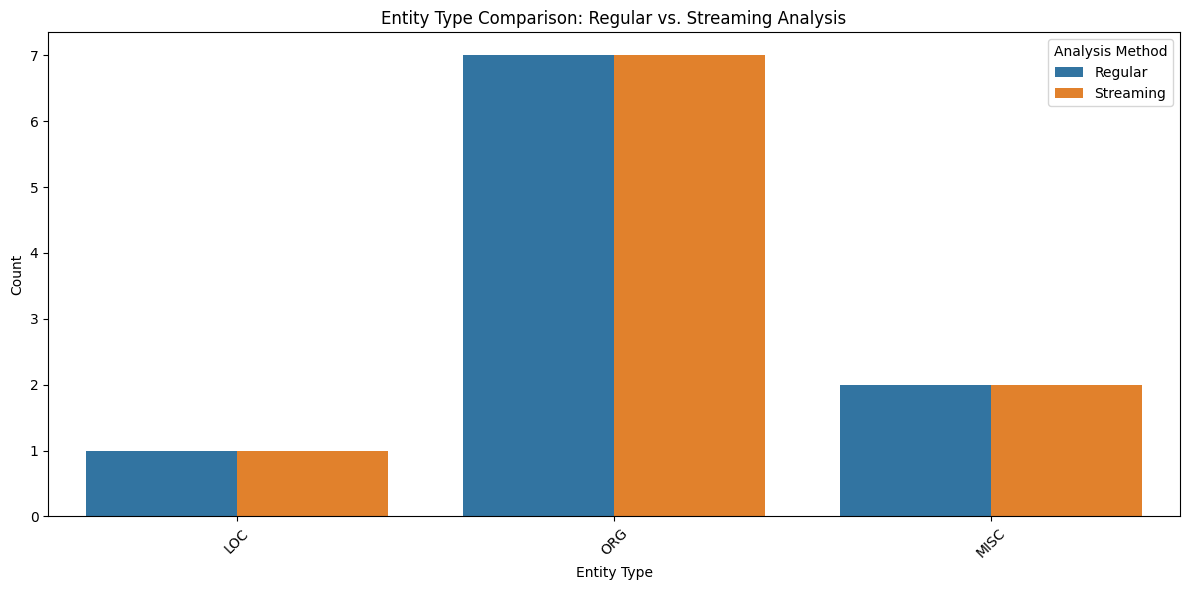


Analysis comparison completed.


In [32]:
def compare_streaming_vs_regular():
    """Compare streaming vs. regular analysis for a long text."""
    # Example long text
    text = """The artificial intelligence conference in Silicon Valley attracted experts from Google, Microsoft, and OpenAI.
    Researchers presented new breakthroughs in natural language processing and computer vision.
    The event was hosted at Stanford University's AI Research Center last month.
    Many discussions focused on ethical implications of advanced AI systems and their potential impact on society.
    Several startups demonstrated innovative applications using transformer-based models for various industries.
    Venture capitalists expressed strong interest in funding new AI initiatives, especially those focused on healthcare.
    The conference concluded with a panel featuring Professors from MIT and Berkeley discussing future research directions."""
    
    print("Comparing streaming vs. non-streaming analysis for the same text...\n")
    print(f"Text length: {len(text)} characters\n")
    
    # 1. Regular (non-streaming) approach
    start_time = time.time()
    
    # Make request to the document endpoint (non-streaming)
    response = requests.post(
        f"{BASE_URL}/streaming/analyze/document",
        headers=headers,
        json={"text": text, "analysis_types": ["sentiment", "entities"]}
    )
    
    regular_result = response.json()
    regular_time = time.time() - start_time
    
    print(f"Regular analysis completed in {regular_time:.2f} seconds")
    
    # 2. Streaming approach (measuring time to first result and total time)
    start_time = time.time()
    first_result_time = None
    all_chunks = []
    
    # Make streaming request
    response = requests.post(
        f"{BASE_URL}/streaming/analyze",
        headers=headers,
        json={"text": text, "analysis_types": ["sentiment", "entities"]},
        stream=True
    )
    
    # Process the SSE stream
    for line in response.iter_lines():
        if line:
            line_str = line.decode('utf-8')
            
            if line_str.startswith("data: "):
                data_json = line_str[6:]
                try:
                    data = json.loads(data_json)
                    
                    # Skip status messages
                    if "status" in data:
                        continue
                    
                    # Record time to first result if not already set
                    if first_result_time is None:
                        first_result_time = time.time() - start_time
                    
                    # Store chunk data
                    all_chunks.append(data)
                    
                except json.JSONDecodeError:
                    pass
    
    streaming_total_time = time.time() - start_time
    
    # Show results comparison
    print(f"Streaming analysis:")
    print(f"  - Time to first result: {first_result_time:.2f} seconds")
    print(f"  - Total time: {streaming_total_time:.2f} seconds")
    print(f"  - Number of chunks: {len(all_chunks)}")
    
    # Create comparison chart
    labels = ['Regular Analysis', 'Streaming (First Result)', 'Streaming (Total)']
    times = [regular_time, first_result_time, streaming_total_time]
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, times, color=['blue', 'green', 'orange'])
    plt.title('Time Comparison: Regular vs. Streaming Analysis')
    plt.ylabel('Time (seconds)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add time labels on top of bars
    for bar, time_val in zip(bars, times):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
                f'{time_val:.2f}s', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Compare entity extraction
    stream_entities = []
    for chunk in all_chunks:
        if 'entities' in chunk:
            stream_entities.extend(chunk['entities'])
    
    regular_entities = []
    if 'entities' in regular_result and 'all_entities' in regular_result['entities']:
        regular_entities = regular_result['entities']['all_entities']
    
    print(f"\nEntity extraction comparison:")
    print(f"  - Regular analysis: {len(regular_entities)} entities found")
    print(f"  - Streaming analysis: {len(stream_entities)} entities found")
    
    # Visualize entity types
    if regular_entities:
        # Count entity types
        regular_entity_types = {}
        for entity in regular_entities:
            entity_type = entity['entity']
            regular_entity_types[entity_type] = regular_entity_types.get(entity_type, 0) + 1
        
        stream_entity_types = {}
        for entity in stream_entities:
            entity_type = entity['entity']
            stream_entity_types[entity_type] = stream_entity_types.get(entity_type, 0) + 1
        
        # Combine and visualize
        all_types = set(list(regular_entity_types.keys()) + list(stream_entity_types.keys()))
        
        comparison_data = {
            'Entity Type': [],
            'Count': [],
            'Method': []
        }
        
        for entity_type in all_types:
            comparison_data['Entity Type'].append(entity_type)
            comparison_data['Count'].append(regular_entity_types.get(entity_type, 0))
            comparison_data['Method'].append('Regular')
            
            comparison_data['Entity Type'].append(entity_type)
            comparison_data['Count'].append(stream_entity_types.get(entity_type, 0))
            comparison_data['Method'].append('Streaming')
        
        df = pd.DataFrame(comparison_data)
        
        plt.figure(figsize=(12, 6))
        sns.barplot(x='Entity Type', y='Count', hue='Method', data=df)
        plt.title('Entity Type Comparison: Regular vs. Streaming Analysis')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.legend(title='Analysis Method')
        plt.tight_layout()
        plt.show()
    
    print("\nAnalysis comparison completed.")

# Run the comparison
compare_streaming_vs_regular() 

## 11. WebSocket Connection

Let's demonstrate the WebSocket API for real-time NLP processing.

In [33]:
class NLPWebSocketClient:
    def __init__(self, url="ws://localhost:8000/api/v1/ws"):
        self.url = url
        self.ws = None
        self.messages = []
        self.connected = False
    
    def on_message(self, ws, message):
        """Callback when a message is received."""
        data = json.loads(message)
        self.messages.append(data)
        print(f"Received: {json.dumps(data, indent=2)}")
    
    def on_error(self, ws, error):
        """Callback for errors."""
        print(f"Error: {error}")
    
    def on_close(self, ws, close_status_code, close_msg):
        """Callback when connection is closed."""
        print("Connection closed")
        self.connected = False
    
    def on_open(self, ws):
        """Callback when connection is established."""
        print("Connection opened")
        self.connected = True
    
    def connect(self):
        """Connect to the WebSocket."""
        self.ws = websocket.WebSocketApp(
            self.url,
            on_open=self.on_open,
            on_message=self.on_message,
            on_error=self.on_error,
            on_close=self.on_close
        )
        
        # Start WebSocket in a background thread
        self.thread = threading.Thread(target=self.ws.run_forever)
        self.thread.daemon = True
        self.thread.start()
        
        # Wait for connection
        time.sleep(1)
        return self.connected
    
    def send(self, data):
        """Send data to the WebSocket."""
        if not self.ws or not self.connected:
            print("Not connected")
            return False
        
        self.ws.send(json.dumps(data))
        return True
    
    def disconnect(self):
        """Disconnect from the WebSocket."""
        if self.ws:
            self.ws.close()
        
        # Wait for thread to finish
        if hasattr(self, 'thread') and self.thread.is_alive():
            self.thread.join(timeout=1)
            
        self.connected = False

In [34]:
# Create and connect the WebSocket client
ws_client = NLPWebSocketClient()
connected = ws_client.connect()

if connected:
    # Try sentiment analysis
    ws_client.send({"action": "sentiment", "text": "I'm really enjoying this API!"})
    time.sleep(1)  # Wait for response
    
    # Try entity recognition
    ws_client.send({"action": "entities", "text": "Google's headquarters are in Mountain View, California."})
    time.sleep(1)  # Wait for response
    
    # Try classification
    ws_client.send({
        "action": "classify", 
        "text": "This computer keeps crashing whenever I open the browser", 
        "labels": ["technical issue", "feedback", "question"]
    })
    time.sleep(1)  # Wait for response
    
    # Wait a bit to receive all responses then disconnect
    time.sleep(2)
    ws_client.disconnect()

Connection opened
Received: {
  "text": "I'm really enjoying this API!",
  "sentiment": "positive",
  "score": 0.9998238682746887,
  "language": "en",
  "processing_time": 0.13604235649108887
}
Received: {
  "text": "Google's headquarters are in Mountain View, California.",
  "entities": [
    {
      "text": "Google",
      "start": 0,
      "end": 6,
      "type": "ORG",
      "score": 0.9988014698028564
    },
    {
      "text": "Mountain View",
      "start": 29,
      "end": 42,
      "type": "LOC",
      "score": 0.9977654218673706
    },
    {
      "text": "California",
      "start": 44,
      "end": 54,
      "type": "LOC",
      "score": 0.9992660880088806
    }
  ],
  "processing_time": 0.3512704372406006
}
Connection closed


## 12. Admin Actions

Let's try using the admin-only endpoint to reload models.

In [35]:
def reload_models():
    """Reload NLP models (admin only)."""
    response = requests.post(
        f"{BASE_URL}/admin/reload-models",
        headers=headers
    )
    
    return response.json()

reload_result = reload_models()
display(JSON(reload_result))

<IPython.core.display.JSON object>

## Conclusion

This notebook demonstrates how to interact with all the major endpoints of the NLP API. You can use this as a starting point to build applications that leverage these natural language processing capabilities.

Here's a summary of what we've explored:

1. Authentication and getting tokens
2. API health checks
3. Sentiment analysis
4. Named entity recognition
5. Text classification
6. WebSocket connections for real-time processing
7. Admin actions for system management

These building blocks can be combined to create powerful NLP-based applications.